In [1]:
%load_ext autoreload
%autoreload 2
import sys

notebook_dir = "/Net/Groups/BGI/scratch/mzehner/code/stacathome/"
sys.path.append(notebook_dir)

In [2]:
import xarray as xr

In [3]:
import numpy as np
import time
import os
from vci import __get_buffer_shift, __get_array_indicators_for_lin_reg
from vci import rolling_linreg, define_time_range, resample_weekly_custom_daterange
from vci import get_vci3m_weekly, get_ndvi_weekly
from vci import load_otf_from_tiffs, find_nearest_indices
from pyproj import CRS, Transformer
import sys

print('Starting at', time.ctime(), flush=True)
i_y = 99
i_x = 99
t = time.perf_counter()

add_weather = False
use_vci3m = False



Starting at Wed Mar 26 09:35:13 2025


In [ ]:

if add_weather:
    print('Loading data at', time.ctime(), flush=True)
    era5_vars = ["pev", "t2m", "tp", "swvl1"]
    era5 = xr.open_zarr("/Net/Groups/BGI/tscratch/vbenson/EarthNet/droughtearthnet/data/Somalia/era5_0d25.zarr")

# temp_offset_era5 = calculate_offset(era5.time.values[0])

start_date = '2016-01-01'
end_date = '2023-12-31'

cube = load_otf_from_tiffs(
    dev_path=None,
    bands=None,
    collection=None,
    tile=None,
    i_y=i_y,
    i_x=i_x,
    c_size=None,
    time_range=[start_date, end_date],
    spat_res=5600,
    subset=False,
    return_box=False,
)
print(cube.time.values[0], cube.time.values[-1], flush=True)

transformer = Transformer.from_crs(4326, cube.spatial_ref.attrs['crs_wkt'], always_xy=True)

if add_weather:
    points_lr = [(transformer.transform(y, x)) for x in era5.lat.values for y in era5.lon.values]
    points_lr_back = [(y, x) for x in era5.lat.values for y in era5.lon.values]
    points_hr = [(y, x) for x in cube.x.values for y in cube.y.values]
    era5_index = [points_lr_back[i] for i in find_nearest_indices(points_hr, points_lr)]

    if not len(np.unique(era5_index, axis=0)) == 1:
        print('found multiple closest era5 pixels', flush=True)
        # implement a dictionary wise approach to forward the correct era5 pixel to the correct cube pixel

if use_vci3m:
    vci_3m_path = f'/Net/Groups/BGI/work_5/scratch/Somalia_VCI_test/37NHE/vci_results/weekly_vci3m_no_smooth_{i_y}_{i_x}.zarr'
    if not os.path.exists(vci_3m_path):
        print('Calculating VCI3M at', time.ctime(), flush=True)
        weekly_vci3m = get_vci3m_weekly(cube, smooth_window_extremes=0).load()
        # -> performance was better forecasting the vci then 3m average

        print('Saving VCI3M at', time.ctime(), flush=True)
        #weekly_vci3m.to_zarr(vci_3m_path, compute=True, mode='w')
        
    else:
        print('Loading VCI3M at', time.ctime(), flush=True)
        weekly_vci3m = xr.open_zarr(vci_3m_path)
    index_data = weekly_vci3m
    forecast_name = 'VCI3M'

else:
    ndvi_path = f'/Net/Groups/BGI/work_5/scratch/Somalia_VCI_test/37NHE/vci_results/weekly_ndvi_{i_y}_{i_x}.zarr'
    if not os.path.exists(ndvi_path):
        weekly_ndvi = get_ndvi_weekly(cube).load()
        weekly_ndvi.to_zarr(ndvi_path, compute=True, mode='w')
    else:
        print('Loading VCI3M at', time.ctime(), flush=True)
        weekly_ndvi = xr.open_zarr(ndvi_path)
        
    index_data = weekly_ndvi
    forecast_name = 'NDVI'

print('index done')

print(index_data.time.values[0], index_data.time.values[-1], flush=True)

era5_resampled = None
if add_weather:
    weekly_era5 = (
        era5.sel(time=slice(start_date, end_date))
        # .resample(time="1W", origin='start_day')
        # .mean()
        .sel(lat=era5_index[0][0], lon=era5_index[0][1], method="nearest")[era5_vars]
        .drop_vars(["lat", "lon"])
    ).load()

    weather_np = weekly_era5.to_array(dim='variable').values

    time_range = define_time_range(weekly_era5.time.values)
    era5_resampled = np.zeros((weather_np.shape[0], time_range.shape[0]))

    for i in range(weather_np.shape[0]):
        era5_resampled[i] = resample_weekly_custom_daterange(weather_np[i, :], weekly_era5.time.values, time_range)
    index_data = index_data.sel(time=slice(weekly_era5.time.values[0], weekly_era5.time.values[-1]))

    print(weekly_era5.time.values[0], weekly_era5.time.values[-1], flush=True)

index_data = index_data.chunk(dict(time=-1, y='auto', x='auto'))

shifts = np.array([-6, -5, -4, -3, -2, -1, 0, 2, 4, 6, 8, 10, 12])
buffer = __get_buffer_shift(shifts)

in_dims = 1
if add_weather:
    in_dims += era5_resampled.shape[0]
shifts_backwards, predict_on = __get_array_indicators_for_lin_reg(shifts, in_dims)

window = 200

print('Calculating VCI3M Forecast at', time.ctime(), flush=True)

forecast = xr.apply_ufunc(
    rolling_linreg,
    index_data,
    input_core_dims=[['time']],
    output_core_dims=[['time', 'shifts']],
    dask_gufunc_kwargs={'output_sizes': {'shifts': predict_on.sum()}},
    dask='parallelized',
    output_dtypes=[np.float32],
    vectorize=True,
    kwargs={
        'weather': era5_resampled,
        'window': window,
        'shifts': shifts,
        'buffer': buffer,
        'shifts_backwards': shifts_backwards,
        'predict_on': predict_on,
    },
).to_zarr(
    f'/Net/Groups/BGI/work_5/scratch/Somalia_VCI_test/37NHE/vci_results/{forecast_name}_no_smooth_forecast_{i_y}_{i_x}.zarr',
    compute=True,
    mode='w',
)

In [4]:
from vci import get_vci3m_weekly_from_ndvi_weekly
use_vci3m = False
if use_vci3m:
    vci3m = xr.open_zarr('/Net/Groups/BGI/work_5/scratch/Somalia_VCI_test/37NHE/vci_results/weekly_vci3m_no_smooth_99_99.zarr')
    forecast = xr.open_zarr('/Net/Groups/BGI/work_5/scratch/Somalia_VCI_test/37NHE/vci_results/VCI_no_smooth_forecast_99_99.zarr')
else:
    # base =  xr.open_zarr('/Net/Groups/BGI/work_5/scratch/Somalia_VCI_test/37NHE/vci_results/weekly_ndvi_99_99.zarr')
    # base = base.chunk(dict(time=-1, y='auto', x='auto'))
    vci3m = get_vci3m_weekly_from_ndvi_weekly(xr.open_zarr('/Net/Groups/BGI/work_5/scratch/Somalia_VCI_test/37NHE/vci_results/weekly_ndvi_99_99.zarr'),return_extrema=True,
                                              smooth_window_extremes=0).compute()
    forecast_ndvi = xr.open_zarr('/Net/Groups/BGI/work_5/scratch/Somalia_VCI_test/37NHE/vci_results/NDVI_no_smooth_forecast_99_99.zarr')
    forecast_ndvi['ndvi_min'] = vci3m['vci3m_weekly'].isel(variables=1).squeeze()
    forecast_ndvi['ndvi_max'] = vci3m['vci3m_weekly'].isel(variables=2).squeeze()
    vci3m['vci3m_weekly'] = vci3m['vci3m_weekly'].isel(variables=0).squeeze()
    forecast = get_vci3m_weekly_from_ndvi_weekly(forecast_ndvi, return_extrema=False, smooth_window_extremes=0).load()

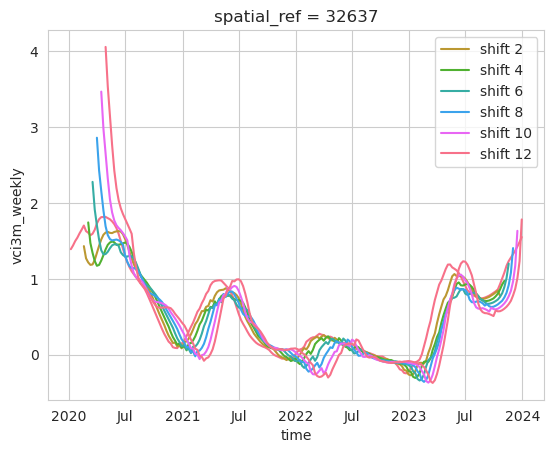

In [9]:
import matplotlib.pyplot as plt
vci3m.sel(time=slice('2020', '2024')).mean(dim=['x', 'y']).vci3m_weekly.plot()
for i in range(6):
    shift = (i+1)*2
    forecast.shift(time=shift).sel(shifts=i).mean(dim=['x', 'y']).vci3m_weekly.plot(label=f"shift {shift}")
    
plt.legend()



In [10]:
import numpy as np

def rmse_score(predictions, targets):
    """
    Calculate the Root Mean Square Error (RMSE) between two numpy arrays.

    Parameters:
    predictions (numpy.ndarray): Predicted values.
    targets (numpy.ndarray): Actual values.

    Returns:
    float: The RMSE value.
    """
    mask = ~np.isnan(predictions) & ~np.isnan(targets)
    predictions = predictions[mask]
    targets = targets[mask]
    return np.sqrt(((predictions - targets) ** 2).mean())

def r2_score(predictions, targets):
    """
    Calculate the R-squared (coefficient of determination) between two numpy arrays.

    Parameters:
    predictions (numpy.ndarray): Predicted values.
    targets (numpy.ndarray): Actual values.

    Returns:
    float: The R-squared value.
    """
    mask = ~np.isnan(predictions) & ~np.isnan(targets)
    predictions = predictions[mask]
    targets = targets[mask]
    ss_res = np.sum((targets - predictions) ** 2)
    ss_tot = np.sum((targets - np.mean(targets)) ** 2)
    return 1 - (ss_res / ss_tot)

Text(0.5, 1.0, 'Eval of VCI3m AR forecast,\n no smoothing of min max')

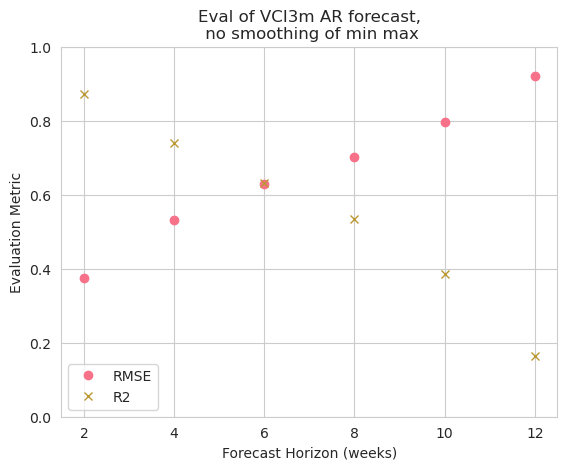

In [11]:
import matplotlib.pyplot as plt
time_frame = slice('2020','2023')

# Extract the data for the selected time slice
original_vci3m = vci3m.sel(time=time_frame).vci3m_weekly




# Plot forecasted VCI3M for each shift
eval_vals = []
for i in range(6):
    forecast_temp = forecast.sel(shifts=i).shift(time=(i+1)*2).sel(time=time_frame).vci3m_weekly
    eval_vals.append(((i+1)*2, 
                      rmse_score(forecast_temp.values.flatten(), original_vci3m.values.flatten()),
                      r2_score(forecast_temp.values.flatten(), original_vci3m.values.flatten())))
    
shift, rmse, r2 = zip(*eval_vals)
plt.plot(shift, rmse, marker='o', lw=0, label='RMSE')
plt.plot(shift, r2, marker='x', lw=0, label='R2')
plt.ylabel('Evaluation Metric')
plt.legend()
plt.xlabel('Forecast Horizon (weeks)')
plt.ylim(0, 1)

plt.title('Eval of VCI3m AR forecast,\n no smoothing of min max')


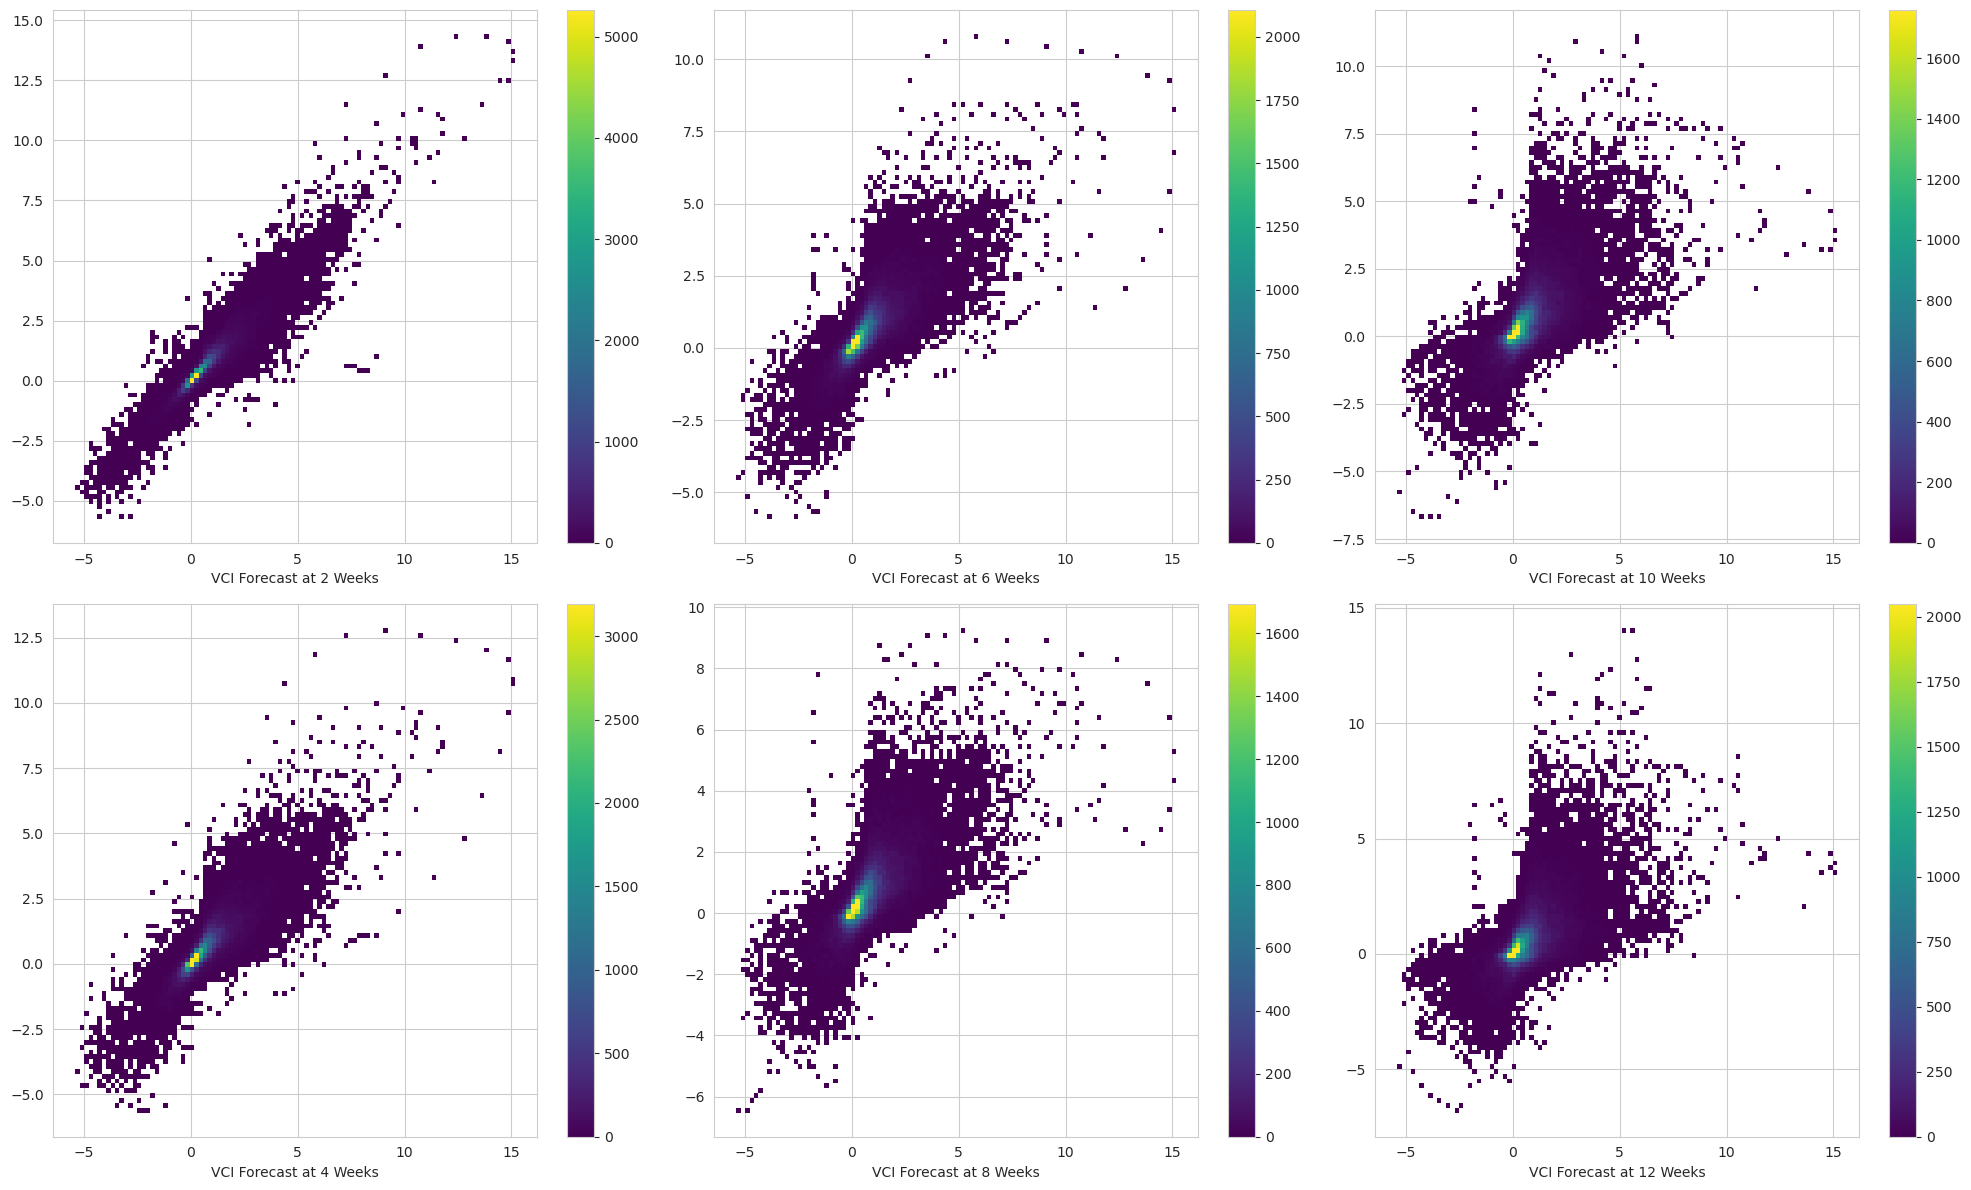

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_palette("husl")

time_frame = slice('2020','2023')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# Flatten the data for scatter plot
x = vci3m.sel(time=time_frame).vci3m_weekly.values.flatten()

for i in range(6):
    y = forecast.sel(shifts=i).shift(time=(i+1)*2).sel(time=time_frame).vci3m_weekly.values.flatten()

    ax = axes[i % 2, i // 2]  # Select the correct subplot
    ax.set_xlabel(f'VCI Forecast at {(i+1)*2} Weeks')

    remove_nan = ~np.isnan(x) & ~np.isnan(y)
    x_temp = x[remove_nan]
    y = y[remove_nan]
    # Use seaborn histplot with hex bins inside the subplot
    sns.histplot(x=x_temp, y=y, bins=100, pmax=0.7, cbar=True, cmap="viridis", ax=ax, kde=False)

plt.tight_layout()
plt.show()